## Fast, robust small short flash detection against noisy background
```
AUTHOR : Mike Tyszka
PLACE  : Pasadena, CA
DATES  : 2025-12-18 JMT From scratch

In [211]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import os.path as op
import time
import cupy as cp
import cupyx.scipy.ndimage as spndx
import cv2
import pandas as pd
from skimage.morphology import disk

# Switch off CUDA for testing on CPU only
# cuda_available = False

# Detect if CUDA is available for CuPy
try:
    cuda_available = cp.cuda.is_available()
except Exception:
    cuda_available = False
    
if cuda_available:

    print("CUDA is available")
    import cupy as npx
    import cupyx.scipy.ndimage as spndx

    print(npx.show_config())

else:
    
    print("CUDA is not available. Using CPU compute")
    import numpy as npx
    import scipy.ndimage as spndx



CUDA is available
OS                           : Windows-11-10.0.26200-SP0
Python Version               : 3.12.0
CuPy Version                 : 13.6.0
CuPy Platform                : NVIDIA CUDA
NumPy Version                : 2.2.6
SciPy Version                : 1.16.3
Cython Build Version         : 3.1.3
Cython Runtime Version       : None
CUDA Root                    : None
nvcc PATH                    : None
CUDA Build Version           : 12090
CUDA Driver Version          : 13010
CUDA Runtime Version         : 12090 (linked to CuPy) / 12010 (locally installed)
CUDA Extra Include Dirs      : []
cuBLAS Version               : (available)
cuFFT Version                : 11002
cuRAND Version               : 10302
cuSOLVER Version             : (11, 4, 4)
cuSPARSE Version             : (available)
NVRTC Version                : (12, 1)
Thrust Version               : 200800
CUB Build Version            : 200800
Jitify Build Version         : <unknown>
cuDNN Build Version          : None
cu

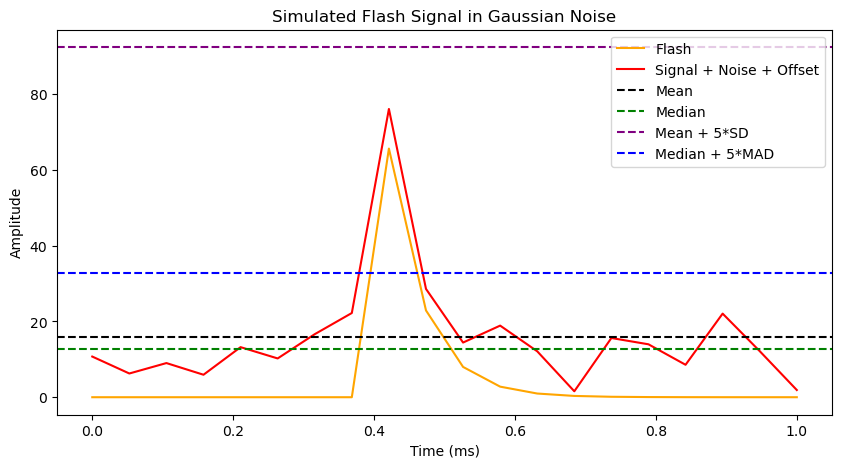

In [212]:
# Simulate 1D flash against Gaussian noise background
fps = 20.0            # Frames per second
block_duration = 1.0  # Duration of block in seconds
nt = int(fps * block_duration)  # Number of time points
sigma_n = 5.0  # Standard deviation of noise
sensor_offset = 10.0  # Sensor offset
A = 100.0       # Amplitude of flash
tau = 0.05      # Time constant of flash decay (seconds)
t0 = 0.4        # Flash start time (seconds)

# Time vector in seconds
t = npx.linspace(0, block_duration, nt)  # Time vector in seconds

# Generate noise
noise = npx.random.normal(0, sigma_n, t.shape)

# Generate flash signal
flash = npx.zeros_like(t)
pre_flash_indices = t < t0
post_flash_indices = t >= t0
flash[post_flash_indices] = A * npx.exp(-(t[post_flash_indices] - t0) / tau)

# Noisy flash signal
signal = noise + flash + sensor_offset

# Clip signal to be non-negative
signal = npx.clip(signal, 0, None)

# Calculate temporal median and MAD of noisy signal
tmedian = npx.median(signal)
tmad = npx.median(npx.abs(signal - tmedian))
tmean = npx.mean(signal)
tstd = npx.std(signal)

# Detection threshold: median + alpha * MAD
alpha = 5.0
rthresh = tmedian + alpha * tmad
thresh = tmean + alpha * tstd

# Plot the results and overlay the temporal median + 2 * MAD
plt.figure(figsize=(10, 5))

if cuda_available:
    t = t.get()
    noise = noise.get()
    flash = flash.get()
    signal = signal.get()
    tmean = tmean.get()
    tmedian = tmedian.get()
    rthresh = rthresh.get()
    thresh = thresh.get()

plt.plot(t, flash, label='Flash', color='orange')
plt.plot(t, signal, label='Signal + Noise + Offset', color='red')
plt.axhline(tmean, color='black', linestyle='--', label='Mean')
plt.axhline(tmedian, color='green', linestyle='--', label='Median')
plt.axhline(thresh, color='purple', linestyle='--', label='Mean + 5*SD')
plt.axhline(rthresh, color='blue', linestyle='--', label='Median + 5*MAD')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Simulated Flash Signal in Gaussian Noise')
plt.legend()
plt.show()

## Synthetic flash in real video

Loaded video shape: 32 x 480 x 720


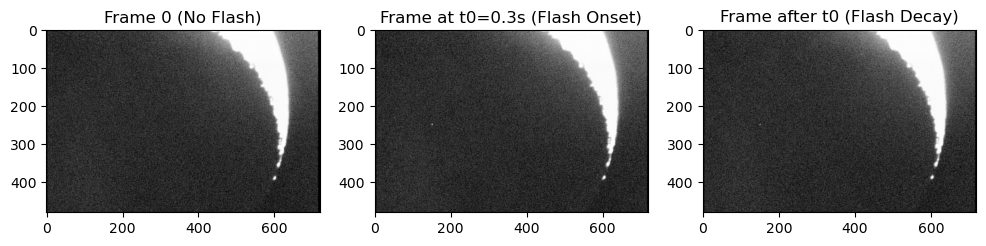

In [213]:
# Load first 32 frames of the ALFI demo AVI video
video_path = "../data/test_video.avi"

# Force FPS to 20 for consistency
fps = 20.0  # Frames per second

# Read video frames using OpenCV
cap = cv2.VideoCapture(video_path)
frames = []
num_frames_to_load = 32
for i in range(num_frames_to_load):
    ret, frame = cap.read()
    if not ret:
        break
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames.append(gray_frame)
cap.release()

signal_block_3d = npx.array(frames)

# Should be (num_frames, height, width)
nt, ny, nx = signal_block_3d.shape
print(f"Loaded video shape: {nt} x {ny} x {nx}")

# Simulate a spatial Gaussian, temporal exponential flash in the video data
flash_sigma_xy = 1.5            # Spatial sigma of Gaussian flash in pixels
flash_amp = 150.0               # Amplitude of flash (8-bit scale)
flash_tau = 0.150               # Time constant of typical LIF (150 ms)
flash_x0, flash_y0 = 150, 250   # Flash center in pixels
flash_t0 = 0.3                  # Flash start time (seconds)

# Create spatial grid
x = npx.arange(nx)
y = npx.arange(ny)
X, Y = npx.meshgrid(x, y)

# Time vector in seconds
t = npx.arange(nt) / fps

# Generate synthetic flash signal over space and time
signal_flash_3d = npx.zeros_like(signal_block_3d)
for i, t_i in enumerate(t):
    if t_i >= flash_t0:
        spatial_component = flash_amp * npx.exp(-(((X - flash_x0) ** 2 + (Y - flash_y0) ** 2) / (2 * flash_sigma_xy ** 2)))
        temporal_component = npx.exp(-(t_i - flash_t0) / flash_tau)
        signal_flash_3d[i] = spatial_component * temporal_component

# Add flash to original signal block
signal_3d = npx.asarray(signal_block_3d + signal_flash_3d)

# Clip signal to range [0, 255]
s = npx.clip(signal_3d, 0, 255)

if cuda_available:
    plt_s = signal_3d.get()
else:
    plt_s = signal_3d

# Display a few frames of the simulated data
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(plt_s[0], cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Frame 0 (No Flash)')
axes[1].imshow(plt_s[int(fps * flash_t0)], cmap='gray', vmin=0, vmax=255)
axes[1].set_title(f'Frame at t0={flash_t0}s (Flash Onset)')
axes[2].imshow(plt_s[int(fps * flash_t0)+1], cmap='gray', vmin=0, vmax=255)
axes[2].set_title('Frame after t0 (Flash Decay)')
plt.show()

## Detection core
- use robust estimate of global
Use drop-in CuPy acceleration of numpy and scipy functions

In [214]:
# Calculate temporal mean and SD of noisy signal at each pixel
t0 = time.perf_counter()
s_tmean = npx.mean(signal_3d, axis=0)
print(f"\ntMean computed in {(time.perf_counter() - t0)*1e3:.2f} ms")

t0 = time.perf_counter()
s_tstd = npx.std(signal_3d, axis=0)
print(f"tSD computed in {(time.perf_counter() - t0)*1e3:.2f} ms")

# Calculate temporal median and MAD of noisy signal at each pixel
t0 = time.perf_counter()
s_tmed = npx.median(signal_3d, axis=0)
print(f"\ntMedian computed in {(time.perf_counter() - t0)*1e3:.2f} ms")

t0 = time.perf_counter()
s_tmad = npx.median(npx.abs(signal_3d - s_tmed), axis=0)
print(f"tMAD computed in {(time.perf_counter() - t0)*1e3:.2f} ms")


tMean computed in 0.47 ms
tSD computed in 0.63 ms

tMedian computed in 81.42 ms
tMAD computed in 69.50 ms


### Compare mean/SD and median/MAD masking

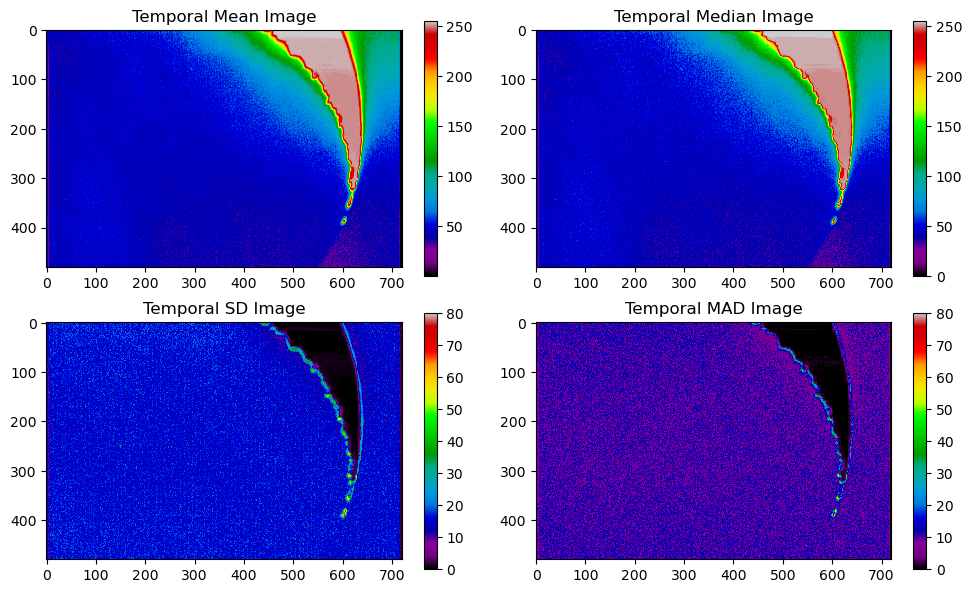

In [215]:
# Display limits for MAD and SD images
madsd_max = 50

# Plot temporal median and MAD images and signal histograms
if cuda_available:
    plt_s_tmean = s_tmean.get()
    plt_s_tstd = s_tstd.get()
    plt_s_tmed = s_tmed.get()
    plt_s_tmad = s_tmad.get()
else:
    plt_s_tmean = s_tmean
    plt_s_tstd = s_tstd
    plt_s_tmed = s_tmed
    plt_s_tmad = s_tmad

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

pp = axs[0, 0].imshow(plt_s_tmean, cmap='nipy_spectral', interpolation='nearest')
axs[0, 0].set_title('Temporal Mean Image')
fig.colorbar(pp, ax=axs[0, 0])

pp = axs[1, 0].imshow(plt_s_tstd, cmap='nipy_spectral', interpolation='nearest', vmax=80)
axs[1, 0].set_title('Temporal SD Image')
fig.colorbar(pp, ax=axs[1, 0])

pp = axs[0, 1].imshow(plt_s_tmed, cmap='nipy_spectral', interpolation='nearest')
axs[0, 1].set_title('Temporal Median Image')
fig.colorbar(pp, ax=axs[0, 1])

pp = axs[1, 1].imshow(plt_s_tmad, cmap='nipy_spectral', interpolation='nearest', vmax=80)
axs[1, 1].set_title('Temporal MAD Image')
fig.colorbar(pp, ax=axs[1, 1])

plt.tight_layout()
plt.show()

#### SD and MAD distributions

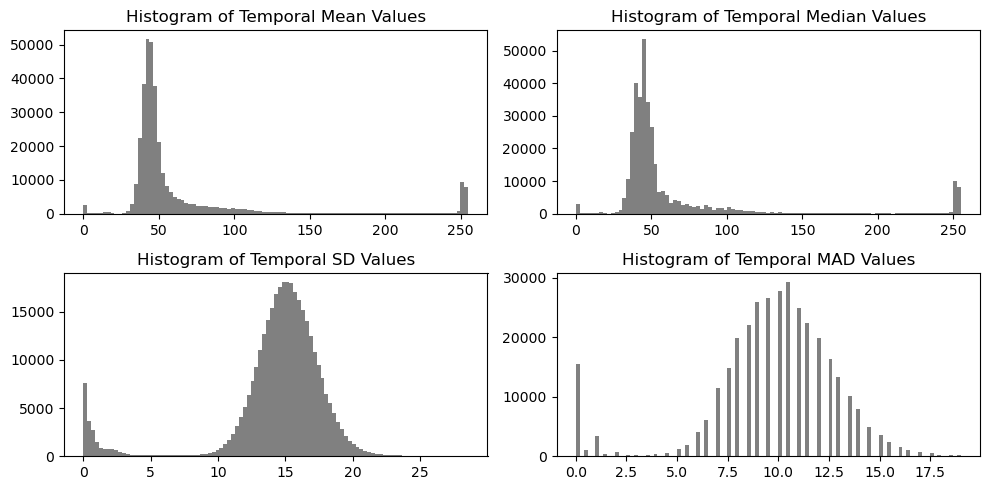

In [216]:
# Pixel exclusion mask thresholding based on SD or MAD distribution
# High or low clipped voxels (~0 and ~255) have very low variance

sd_p99 = npx.percentile(s_tstd, 99.5)
mad_p99 = npx.percentile(s_tmad, 99.5)

hist_bins = npx.linspace(0, 255, 100)
sd_bins = npx.linspace(0, sd_p99, 100)
mad_bins = npx.linspace(0, mad_p99, 100)

if cuda_available:
    plt_hist_bins = hist_bins.get()
    plt_sd_bins = sd_bins.get()
    plt_mad_bins = mad_bins.get()
else:
    plt_hist_bins = hist_bins
    plt_sd_bins = sd_bins
    plt_mad_bins = mad_bins

fig, axs = plt.subplots(2, 2, figsize=(10, 5))

f_mean, bins_mean, _ = axs[0, 0].hist(plt_s_tmean.flatten(), bins=plt_hist_bins, color='gray')
axs[0, 0].set_title('Histogram of Temporal Mean Values')

f_std, bins_std, _ = axs[1, 0].hist(plt_s_tstd.flatten(), bins=plt_sd_bins, color='gray')
axs[1, 0].set_title('Histogram of Temporal SD Values')

f_med, bins_med, _ = axs[0, 1].hist(plt_s_tmed.flatten(), bins=plt_hist_bins, color='gray')
axs[0, 1].set_title('Histogram of Temporal Median Values')

f_mad, bins_mad, _ = axs[1, 1].hist(plt_s_tmad.flatten(), bins=plt_mad_bins, color='gray')
axs[1, 1].set_title('Histogram of Temporal MAD Values')

plt.tight_layout()
plt.show()

#### Exclusion mask construction
- Use pixel signal temporal SD to identify and exlude both clipped/saturated voxels with low SD
- Model temporal SD distribution as Gaussian mixture with clipped component close to zero and sensor noise component around 10-20 mean
- Calculate optimal discrimination boundary between clipped and noise Gaussians using naive Bayes


In [217]:
# Gaussian mixture model to SD histogram for pixel exclusion thresholding
from sklearn.mixture import GaussianMixture

# Subsample full SD distribution for GMM fitting if too large
max_pixels = 5000
if s_tstd.size > max_pixels:
    step = int((s_tstd.size / max_pixels) ** 0.5)
    s_tstd_sub = s_tstd[::step, ::step]
    print(f"Subsampling SD values for GMM fitting: step={step}, new size={s_tstd_sub.shape}")
    sd_values = s_tstd_sub.flatten().reshape(-1, 1)
else:
    sd_values = s_tstd.flatten().reshape(-1, 1)

print("Number of pixels:", sd_values.shape[0])

model = GaussianMixture(n_components=2, covariance_type='full', random_state=0)

t0 = time.perf_counter()
model.fit(sd_values.get() if cuda_available else sd_values)
print(f"GMM fitted in {(time.perf_counter() - t0)*1e3:.2f} ms")
weights = model.weights_.flatten()
means = model.means_.flatten()
sds = model.covariances_.flatten() ** 0.5

# Select larger gaussian component as sensor noise
noise_component = means.argmax()
clipped_component = 1 - noise_component

w_clipped = weights[clipped_component]
m_clipped = means[clipped_component]
sd_clipped = sds[clipped_component]

w_noise = weights[noise_component]
m_noise = means[noise_component]
sd_noise = sds[noise_component]

print(f"GMM Clipped Component: Weight={w_clipped:.2f}, Mean={m_clipped:.2f}, SD={sd_clipped:.2f}")
print(f"GMM Noise Component: Weight={w_noise:.2f}, Mean={m_noise:.2f}, SD={sd_noise:.2f}")

# Use the naive Bayes discrimination boundary as the exclusion threshold where P(noise) = P(clipped)
# Reference:
# Duda, R. O., Hart, P. E., & Stork, D. G. (2001). Pattern Classification (2nd Edition),
# Section 2.5.2: "Normal Density: Discriminant Functions for the Normal Density". Wiley-Interscience.
nbd = (
        ( (m_clipped**2) - (m_noise**2) ) + 
        2 * (sd_clipped**2 * npx.log(w_noise * sd_clipped) - sd_noise**2 * npx.log(w_clipped * sd_noise)) 
    ) / (2 * (m_clipped - m_noise))

print(f"Naive Bayes discrimination boundary: {nbd:.2f}")

# Lower threshold avoids clipped voxels
tsd_thresh_low = nbd

# Upper threshold to exclude unusually high tSD pixels but cap at 255
tsd_thresh_high = m_noise + 10 * sd_noise
if tsd_thresh_high > 255:
    tsd_thresh_high = 255.0

print(f"\ntSD Exclusion thresholds: Low={tsd_thresh_low:.2f}, High={tsd_thresh_high:.2f}")


Subsampling SD values for GMM fitting: step=8, new size=(60, 90)
Number of pixels: 5400
GMM fitted in 10.21 ms
GMM Clipped Component: Weight=0.06, Mean=0.97, SD=1.05
GMM Noise Component: Weight=0.94, Mean=16.22, SD=2.79
Naive Bayes discrimination boundary: 7.72

tSD Exclusion thresholds: Low=7.72, High=44.13


Structured element radius: 11
Exclude mask dilation in 2.15 ms


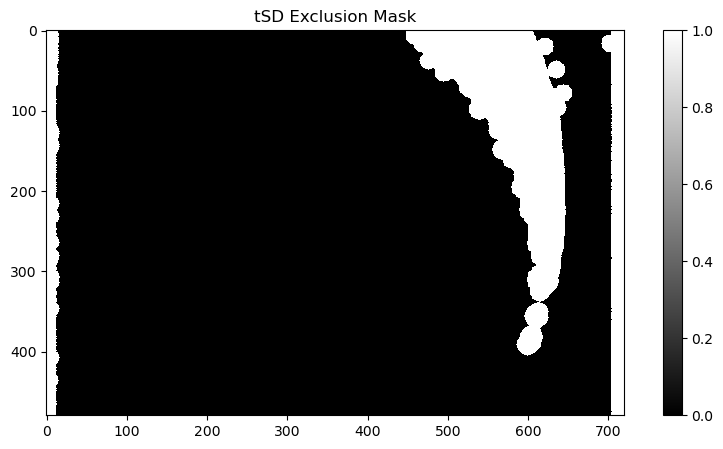

In [218]:
# Exclude clipped pixels with tSD below threshold
exclude_mask = (s_tstd < tsd_thresh_low) | (s_tstd > tsd_thresh_high)

# Dilate mask using a k-pixel diameter circular structured element
# Set k in UI config tab
r_disk = 11
footprint = disk(r_disk).astype(npx.uint8)
print(f'Structured element radius: {r_disk}')

t0 = time.perf_counter()
exclude_mask = spndx.maximum_filter(exclude_mask.astype(npx.uint8), footprint=footprint) > 0
print(f"Exclude mask dilation in {(time.perf_counter() - t0)*1e3:.2f} ms")

if cuda_available:
    plt_exclude_mask = exclude_mask.get()
else:
    plt_exclude_mask = exclude_mask

fig, axs = plt.subplots(figsize=(10, 5))
pp = axs.imshow(plt_exclude_mask, cmap='gray', interpolation='nearest')
axs.set_title('tSD Exclusion Mask')
fig.colorbar(pp, ax=axs)
plt.show()

#### Phase 1 statistical detection of anomalies

Masked Gaussian filtering computed in 1.74 ms


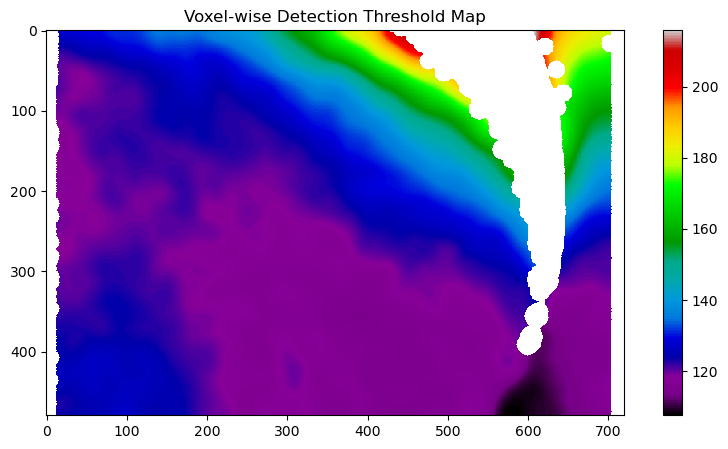

In [235]:
# Create a 2D spatial threshold map from the temporal mean and sd
alpha = 5.0  # Threshold scaling factor
thresh_map = s_tmean + alpha * s_tstd

# Add pixels with thrshold > 255 to exclusion mask
exclude_mask = exclude_mask | (thresh_map > 255)

# Masked gaussian filtering to smooth threshold map while ignoring NaNs
def masked_gaussian_filter(image, mask, sigma):
    """Apply Gaussian filter to image while ignoring masked values."""
    image_filled = npx.where(mask, 0, image)
    filtered_image = spndx.gaussian_filter(image_filled, sigma=sigma)
    normalization = spndx.gaussian_filter((~mask).astype(npx.float32), sigma=sigma)
    normalization = npx.where(normalization == 0, npx.nan, normalization)
    return filtered_image / normalization

# Apply masked Gaussian filtering to threshold map
# Using sigma=10.0 as an example; set from UI config tab
t0 = time.perf_counter()
thresh_map = masked_gaussian_filter(thresh_map, exclude_mask, sigma=10.0)
print(f"Masked Gaussian filtering computed in {(time.perf_counter() - t0)*1e3:.2f} ms")

# Reapply exclusion mask to threshold map
thresh_map = npx.where(exclude_mask, npx.nan, thresh_map)

if cuda_available:
    plt_thresh_map = thresh_map.get()
else:
    plt_thresh_map = thresh_map

fig, axs = plt.subplots(figsize=(10, 5))
plt.imshow(plt_thresh_map, cmap='nipy_spectral', interpolation='nearest')
plt.title('Voxel-wise Detection Threshold Map')
plt.colorbar()
plt.show()

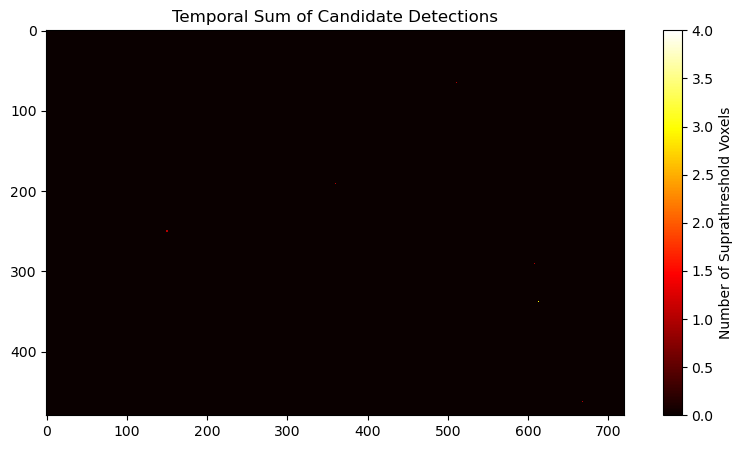

In [237]:
# Threshold the signal to create candidate anomaly detections
thresh_map_3d = npx.expand_dims(thresh_map, axis=0)
suprathreshold_3d = signal_3d >= thresh_map_3d

# Display temporal sum of suprathreshold voxels
detection = suprathreshold_3d.astype(npx.uint8)
detection_tsum = npx.sum(detection, axis=0)

if cuda_available:
    d_tsum = detection_tsum.get()
else:
    d_tsum = detection_tsum

fig, axs = plt.subplots(figsize=(10, 5))
plt.imshow(d_tsum, cmap='hot', interpolation='nearest')
plt.title('Temporal Sum of Candidate Detections')
plt.colorbar(label='Number of Suprathreshold Voxels')
plt.show()

#### Phase 2 detection filtering
Apply sensible limits to connected regions in suprathreshold temporal sum map

In [ ]:
# Run connected components analysis on the suprathreshold temporal sum image
from skimage.measure import regionprops

# Binarize temporal sum image for morphological analysis
detection_bin = detection_tsum > 0

t0 = time.perf_counter()
labels, num_features = spndx.label(detection_bin)

if cuda_available:
    prop_labels = labels.get()
else:
    prop_labels = labels

regions = regionprops(prop_labels, intensity_image=d_tsum)
print(f"Connected components analysis completed in {(time.perf_counter() - t0)*1e3:.2f} ms")

print(f"Number of candidate detections: {len(regions)}")

anomaly_list = []

for region in regions:

    # Get XY bounding box of region
    bb_xy = region.bbox

    # Extract bounding box subregion from suprathreshold 3D mask
    supra_bb_xy = suprathreshold_3d[:, bb_xy[0]:bb_xy[2], bb_xy[1]:bb_xy[3]]

    # Get temporal bounding box
    supra_indices = npx.where(supra_bb_xy)
    t_min, t_max = int(npx.min(supra_indices[0])), int(npx.max(supra_indices[0])+1)

    # Duration of temporal bounding box in seconds
    duration = (t_max - t_min) / fps

    # Apply phase 2 candidate criteria
    candidate = duration > 0.05 and duration < 0.20 and region.area >= 5 and region.area <= 20

    if candidate:
        anomaly_list.append({
            'label': region.label,
            'x_min': bb_xy[1],
            'x_max': bb_xy[3],
            'y_min': bb_xy[0],
            'y_max': bb_xy[2],
            't_min': t_min,
            't_max': t_max,
            'duration_s': duration,
            'area_px': region.area,
            'com_x': region.centroid[1],
            'com_y': region.centroid[0],
        })

# Convert to dataframe for easier viewing
anomaly_df = pd.DataFrame(anomaly_list)
print(anomaly_df)

Connected components analysis completed in 5.68 ms
Number of candidate detections: 10
   label  x_min  x_max  y_min  y_max  t_min  t_max  duration_s  area_px  \
0      3    149    152    249    252      6      8         0.1      9.0   

   com_x  com_y  
0  150.0  250.0  


#### Display candidate flashes in this block

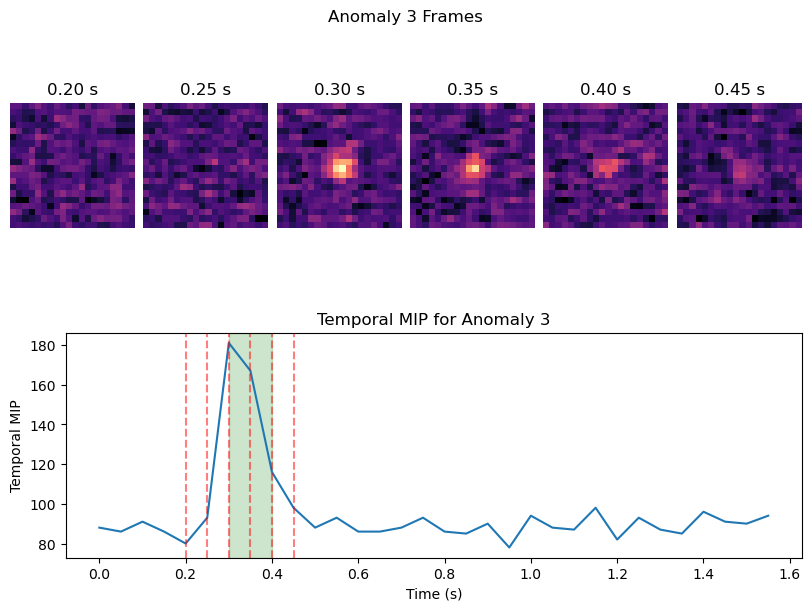

In [239]:
for anomaly in anomaly_list:
    
    l = anomaly['label']
    bb_t_min = anomaly['t_min']
    bb_t_max = anomaly['t_max']
    bb_y_min = anomaly['y_min']
    bb_y_max = anomaly['y_max']
    bb_x_min = anomaly['x_min']
    bb_x_max = anomaly['x_max']
    com_x = anomaly['com_x']
    com_y = anomaly['com_y']

    # Time vector in seconds for bounding box
    bb_t_secs = npx.arange(bb_t_min, bb_t_max) / fps

    # Extract small region around flash CoM
    hw = 10  # Half width of region
    roi_x_min = int(max(com_x - hw, 0))
    roi_x_max = int(min(com_x + hw, signal_3d.shape[2]))
    roi_y_min = int(max(com_y - hw, 0))
    roi_y_max = int(min(com_y + hw, signal_3d.shape[1]))
    flash_region = signal_3d[:, roi_y_min:roi_y_max, roi_x_min:roi_x_max]

    # Create horizontal montage of XY slices through flash region center for two frames before and after flash onset
    montage_t_start = max(bb_t_min - 2, 0)
    montage_t_end = min(bb_t_max + 2, signal_3d.shape[0])
    montage_frames = []
    for frame_idx in range(montage_t_start, montage_t_end):
        slice_xy = flash_region[frame_idx, :, :]
        montage_frames.append(slice_xy)

    # Extract flash MIP profile
    flash_profile = npx.max(npx.max(flash_region, axis=2), axis=1)

    if cuda_available:
        plt_t = t.get()
        plt_flash_profile = flash_profile.get()
        plt_montage = npx.array(montage_frames).get()
    else:
        plt_t = t
        plt_flash_profile = flash_profile
        plt_montage = npx.array(montage_frames)

    # Plot anomaly results in space and time
    # Plot individual frames in as separate axes in row one
    # Plot anomaly temporal profile in row two, spanning all columns

    # Create 2x1 subplots
    fig, axs = plt.subplots(nrows=2, ncols=1, constrained_layout=True, figsize=(8, 6))

    # Clear subplots
    for ax in axs:
        ax.remove()

    # Create list of subfigures for each row
    gridspec = axs[0].get_subplotspec().get_gridspec()
    subfigs = [fig.add_subfigure(gs) for gs in gridspec]

    # Add subplots to first row
    subfigs[0].suptitle(f'Anomaly {l} Frames')

    # Create n_roi_frame subplots in top row subfigure
    n_montage_frames = len(montage_frames)

    # Get grand scaling max for montage frames
    grand_max = npx.max(plt_montage)

    axs_toprow = subfigs[0].subplots(nrows=1, ncols=n_montage_frames)
    for col, ax in enumerate(axs_toprow):
        ax.imshow(plt_montage[col], cmap='magma', vmax=grand_max)
        ax.axis('off')
        # Set title to time in seconds
        ax.set_title(f'{plt_t[montage_t_start + col]:.2f} s')

    ax_bottomrow = subfigs[1].subplots(nrows=1, ncols=1)
    ax_bottomrow.plot(plt_t, plt_flash_profile)

    # Add transparent green box to indicate detected flash duration
    ax_bottomrow.axvspan(float(bb_t_min)/fps, float(bb_t_max)/fps, color='green', alpha=0.2)

    # Add box markers for frames shown in montage
    for frame_idx in range(montage_t_start, montage_t_end):
        ax_bottomrow.axvline(plt_t[frame_idx], color='red', linestyle='--', alpha=0.5)

    ax_bottomrow.set_xlabel('Time (s)')
    ax_bottomrow.set_ylabel('Temporal MIP')
    ax_bottomrow.set_title(f'Temporal MIP for Anomaly {l}')

    plt.show()